# Kaggle Competition:  Iceberg or Ship

# resnext50 architecture (rest is Grover's options)
### see if log_loss=0.29 from resnet18 can be improved

## increase from sz=75, resize 1.5x

---
## Import libraries

In [1]:
!ls -l

total 2300
-rw-rw-r-- 1 ubuntu ubuntu 625023 Jan 14 18:47 1_getdata.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 245619 Jan 14 18:36 2_model_resnet34.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  13445 Jan 14 18:36 3_model_resnext50.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  14220 Jan 13 21:14 4_model_nasnet.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  64965 Jan 14 19:40 4_resnext_resize.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 147078 Jan 14 19:57 5_resnet18_resize.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 138629 Jan 14 19:52 6_resnext50_resize.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 176126 Jan 14 21:22 7_resnext50_sz_100.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 137540 Jan 14 18:36 baseline.ipynb
-rw-rw-r-- 1 ubuntu ubuntu    536 Jan 14 18:36 helper.py
-rw-rw-r-- 1 ubuntu ubuntu 767392 Jan 14 18:36 other_groverpr.ipynb
drwxrwxr-x 2 ubuntu ubuntu   4096 Jan 14 18:51 __pycache__
-rw-rw-r-- 1 ubuntu ubuntu    745 Jan 14 20:14 README.md


In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *

In [4]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd
import numpy as np
import shutil
from IPython.display import FileLink, FileLinks

from sklearn.model_selection import train_test_split
import helper

In [5]:
#PATH = "/home/nidhin/data/iceberg/"
PATH = os.path.expanduser("~/data/iceberg/")

In [6]:
!ls -l {PATH}

total 1973260
drwxrwxr-x  2 ubuntu ubuntu       4096 Jan  9 00:38 models
-rw-rw-r--  1 ubuntu ubuntu     117951 Oct 23 17:27 sample_submission.csv
-rw-rw-r--  1 ubuntu ubuntu      38566 Jan  7 20:36 sample_submission.csv.7z
drwxrwxr-x  2 ubuntu ubuntu     274432 Jan 14 18:44 test
-rw-rw-r--  1 ubuntu ubuntu 1521771850 Oct 23 17:27 test.json
-rw-rw-r--  1 ubuntu ubuntu  257127394 Jan  7 20:36 test.json.7z
drwxrwxr-x 49 ubuntu ubuntu       4096 Jan 14 20:45 tmp
drwxrwxr-x  4 ubuntu ubuntu       4096 Jan 14 18:43 train
-rw-rw-r--  1 ubuntu ubuntu  196313674 Oct 23 17:23 train.json
-rw-rw-r--  1 ubuntu ubuntu   44932785 Jan  7 20:36 train.json.7z
drwxrwxr-x  4 ubuntu ubuntu       4096 Jan 14 18:43 valid


In [7]:
np.random.seed(0)

## Set Architecture

In [8]:
arch=resnext50
sz=75
bs=32
lr = 1e-2

In [9]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.00)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs,test_name='test')
    return data

data = get_data(sz, bs)
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [10]:
#tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
#data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs,test_name='test',)

learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.6)

### Learning Rate Finder

In [11]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 66%|██████▌   | 27/41 [00:00<00:00, 28.87it/s, loss=6.86] 


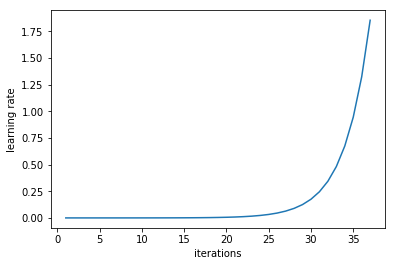

In [12]:
learn.sched.plot_lr()

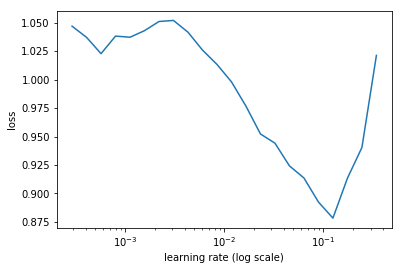

In [13]:
learn.sched.plot() 

In [14]:
learn.fit(lr, 8)
learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

[0.      0.64265 0.45734 0.72443]                          
[1.      0.58209 0.38807 0.84375]                          
[2.      0.51224 0.45791 0.73864]                          
[3.      0.54098 0.38152 0.86079]                          
[4.      0.54162 0.57359 0.74148]                          
[5.      0.48968 0.51846 0.72159]                          
[6.      0.43918 0.4479  0.75   ]                          
[7.      0.4048  0.49915 0.8125 ]                          



### Stochastic Gradient Descent with Restart

In [15]:
#learn.fit(lr, 4, cycle_len=2)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.60313 0.5866  0.79546]                          
[1.      0.54297 0.42287 0.80398]                          
[2.      0.53381 0.44965 0.80114]                          
[3.      0.53571 0.46698 0.80682]                          
[4.      0.54504 0.50014 0.78409]                          
[5.      0.52699 0.47361 0.78693]                          
[6.      0.50897 0.46412 0.79829]                          



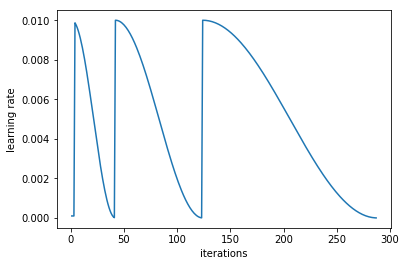

In [16]:
learn.sched.plot_lr()

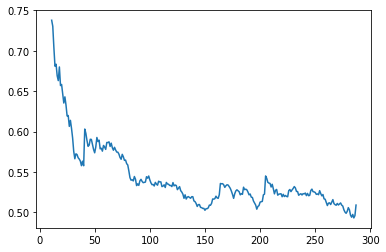

In [17]:
learn.sched.plot_loss()

In [18]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),axis=0)
(metrics.log_loss(y,preds), accuracy(preds,y))

(0.34738994405289925, 0.8473520249221184)

In [19]:
# lr/10

In [20]:
# lr/9

In [21]:
# lr/3

In [22]:
# lr/4

### Unfreeze Layers

In [23]:
# unfreeze layers
learn.unfreeze()
#lrs = np.array([lr/15,lr/12,lr/9])
lrs = np.array([lr/9,lr/3,lr/1])

#wd = 0.025
#wds=[wd/100, wd/10, wd]
#wds=[0.0025,0.025,0.25]


### Run Learner Again

In [24]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
#learn.fit(lrs, 5, cycle_len=1, cycle_mult=2,use_wd_sched=True,wds=wds)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.58626 0.39479 0.82102]                          
[1.      0.60695 3.14936 0.70739]                          
[2.      0.52448 0.56008 0.75   ]                          
[3.      0.489   1.26268 0.66761]                          
[4.      0.49952 0.67712 0.73864]                          
[5.      0.44766 0.57124 0.78693]                          
[6.      0.41437 0.66695 0.79546]                          



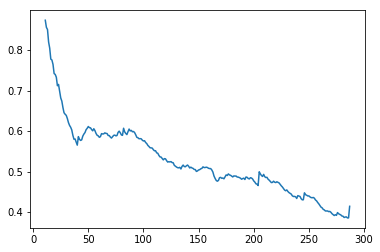

In [25]:
learn.sched.plot_loss()

In [26]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),axis=0)
(metrics.log_loss(y,preds), accuracy(preds,y))

(0.3169515312566414, 0.8504672897196262)

In [27]:
learn.save('resnext50_sz75_zm12')

In [28]:
learn.load('resnext50_sz75_zm12')

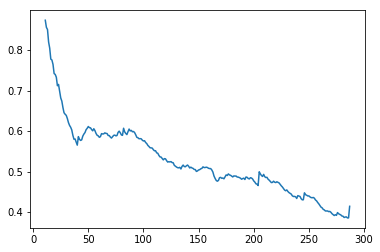

In [29]:
learn.sched.plot_loss()

In [30]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),axis=0)
(metrics.log_loss(y,preds), accuracy(preds,y))

(0.3138132471278111, 0.8504672897196262)

### Run Learner again

In [31]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.42601 0.60856 0.77273]                          
[1.      0.42695 0.64841 0.8125 ]                          
[2.      0.40172 0.60374 0.80398]                          
[3.      0.43415 0.38573 0.83239]                          
[4.      0.42632 0.40595 0.81534]                          
[5.      0.42311 0.33094 0.83523]                          
[6.      0.39453 0.3958  0.81534]                          



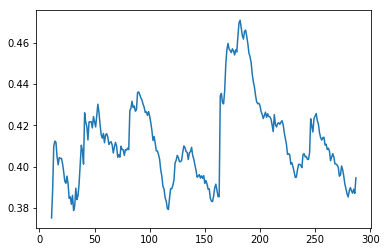

In [32]:
learn.sched.plot_loss()

### Run Learner again

In [33]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.3332  0.31534 0.83523]                          
[1.      0.36606 0.38689 0.79829]                          
[2.      0.3379  0.35744 0.83239]                          
[3.      0.35318 0.31905 0.86364]                          
[4.      0.36305 0.35403 0.83807]                          
[5.      0.36661 0.33279 0.83807]                          
[6.      0.33856 0.34332 0.84375]                          



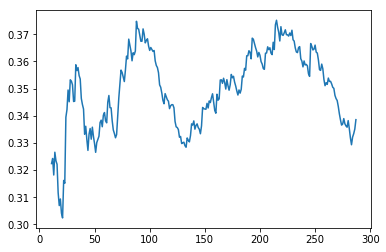

In [34]:
learn.sched.plot_loss()

## Log Loss | Accuracy (final model here)

In [35]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),axis=0)
(metrics.log_loss(y,preds), accuracy(preds,y))

(0.27831638091989297, 0.8753894080996885)

## Save predictions

In [36]:
# test_df = pd.read_json(PATH+"/test.json")
# helper.make_test_file(log_preds,test_df,model_name='resnext50_sz75_zm15_bs32_comp_band',
#                       classes=data.classes,
#                       submission_folder =f'{PATH}sub'
#                      )